In [73]:
import pandas as pd 
import numpy as np 
from langdetect import detect

## Get data

In [74]:
#data = pd.read_excel('List_Songs-HIPPOP.xlsx')
data = pd.read_csv('List_Songs_Lyrics_test2.csv',lineterminator='\n')

# Overview of the rows that are dropped

In [75]:

print('Initial number of songs', len(data))

data1 = data[data.Lyrics != 'NONE']

print('After removal of songs with no lyrics' , len(data1))

data2 = data1.loc[data1['Lyrics'].apply(detect) == 'en']
print('Number of remaining songs that are not in English', len(data2))
 
# Split into two dataframes by genre    
pop_df = data2[['Lyrics','Title','Year']].loc[data2['Genre'] == 'Pop']
hiphop_df = data2[['Lyrics','Title','Year']].loc[data2['Genre'] == 'Hip Hop']

# Inner join to get the songs that are in both
df12 = pd.merge(hiphop_df,pop_df, on=['Title','Year','Lyrics'], how='inner')     #extract common rows with merge
final_hiphop = hiphop_df[~hiphop_df['Lyrics'].isin(df12['Lyrics'])]
final_pop = pop_df[~pop_df['Lyrics'].isin(df12['Lyrics'])]

print('Number of songs that are in both genres (and thus removed twice)',len(df12))

final_hiphop.head(100)

Initial number of songs 1440
After removal of songs with no lyrics 1076
Number of remaining songs that are not in English 968
Number of songs that are in both genres (and thus removed twice) 358


,Lyrics,Title,Year
960,Uh uh uh\nI just gotta bring it to they attent...,#1,2002
961,\n\nChorus (2x):(Mannie Fresh)\nAll the nigga...,#1,2002
962,[Rich Nice] What I want you to understand is...,#1 Player,1995
963,Nigga can't out-stunt me when it come to these...,#1 Stunna,2000
964,Girl it's your birthday (birthday) in here (in...,#BDAY,NONE
...,...,...,...
1107,Up out of there Ain't nothin' but a gangsta p...,2 of Amerikaz Most Wanted,1996
1108,Up out of there [daz repeated several times ...,2 of Amerikaz Most Wanted,1998
1109,Up out of there Ain't nothin' but a gangsta p...,2 of Amerikaz Most Wanted,2004
1110,[Snoop Talking] Up out of there [Daz repeat...,2 of Amerikaz Most Wanted,1998


# Data tidying function

In [76]:
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [77]:
def tidy_data(df):
    start_len = len(df)
    ### Function that takes as input the dataframe and outputs the clean dataframe 
    
    # Drop rows where Lyrics = None
    df = df[df.Lyrics != 'NONE']
    
    # Get genre dummies 
    dummy=pd.get_dummies(df["Genre"])
    df = pd.concat([df, dummy], axis=1)
    
    # Detect language and drop all rows where language is not English
    df['Language'] = df['Lyrics'].apply(detect)
    df = df.loc[df['Language'] == 'en']
    df = df.drop(['Language'], axis=1)
    
    # Find lyrics that are in both genres and remove them both 
    # Split into two dataframes by genre    
    pop_df = data2[['Lyrics','Title','Year']].loc[data2['Genre'] == 'Pop']
    hiphop_df = data2[['Lyrics','Title','Year']].loc[data2['Genre'] == 'Hip Hop']

    # Inner join to get the songs that are in both
    df12 = pd.merge(hiphop_df,pop_df, on=['Title','Year','Lyrics'], how='inner')     #extract common rows with merge
    final_hiphop = hiphop_df[~hiphop_df['Lyrics'].isin(df12['Lyrics'])]
    final_pop = pop_df[~pop_df['Lyrics'].isin(df12['Lyrics'])]
    
    #Combine
    hiphop_pop_concat = pd.concat([final_hiphop,final_pop])
    #Put 'Genres' back on
    final_df = pd.merge(hiphop_pop_concat,pd.DataFrame(df[['Lyrics','Genre']]),on='Lyrics',how='left')
    
    #df = df.drop_duplicates(subset=['Lyrics', 'Title', 'Year'], keep=False)
    final_df = final_df.drop_duplicates()
    
    final_df['Year'].replace('NONE',None, inplace=True)
    
    #Apply tokenizer
    final_df['Lyrics'] = final_df['Lyrics'].apply(spacy_tokenizer)
    
    tidied_len = len(final_df)
    print('Function removed', start_len - tidied_len, 'out of', start_len, 'rows')
    
    return final_df #(df)

In [78]:
data = tidy_data(data)
data.head(10)

Function removed 1141 out of 1440 rows


,Lyrics,Title,Year,Genre
0,"[uh, uh, uh, bring, attention, dirty, watch, t...",#1,2002,Hip Hop
1,"[chorus, 2x):(mannie, fresh, niggas, buck, buc...",#1,2002,Hip Hop
2,"[rich, nice, want, understand, mackin, big, bu...",#1 Player,1995,Hip Hop
3,"[nigga, stunt, come, f*ckin, car, nigga, belie...",#1 Stunna,2000,Hip Hop
4,"[girl, birthday, birthday, tonight, tonight, g...",#BDAY,2000,Hip Hop
5,"[grind, mode, grind, mode, bitch, grind, mode,...",#Grindmode,2000,Hip Hop
6,"[big, man, talk, hear, weh, yuh, fi, shut, mou...",#Twerkit,2000,Hip Hop
7,"[rich, girl, come, far, know, matt, rely, old,...",$$$ Girlz,2004,Hip Hop
8,"[uh, uh, uh, ready, b, let, 'em, look, young, ...",'03 Bonnie & Clyde,2002,Hip Hop
14,"[uh, uh, uh, ready, b, let, 'em, look, young, ...",'03 Bonnie & Clyde,2003,Hip Hop


In [79]:

#len(data.loc[data['Genre'] == 'Hip Hop'])
#len(data.loc[data['Genre'] == 'Pop'])

# Descriptive analysis - the year variable

Ideas: 
- Do we swear more now than before? 
- Do newer songs use more disrespectful language towards women? 
- Which genres swear more? (obvious...) 

Calculate avg number of swear words per song.
- Get list of swear words 
- Count how many swear words in each song - store number in new column 
- avg(number_of_swearwords) group by year, genre 


In [88]:
# Differences in 
# Do we swear more now than before? (get list of swear-words and count by year)
profanity_url = 'http://www.bannedwordlist.com/lists/swearWords.txt'
#profanity = pd.read_csv(profanity_url, header=None, sep = '\n')

import requests

profanity = requests.get(profanity_url).text
profanity = set(profanity.split('\r\n'))

extras = {'f*ck','f**k','f*cked','f*ckin','f*cking','nigga', 'niggas', 'b*tch', 'bitches', 'b*tches'}

prof = profanity.union(extras)

In [89]:
def profanity_check(document, dictionary):
    list_match = []
    
    for word in document: 
        if word in dictionary:
             list_match.append(word)

    return len(list_match)
    

In [90]:
data['Profanity_count'] = data['Lyrics'].apply(profanity_check, args=[prof])
data['Year_decade'] = pd.to_numeric(data['Year'])//10*10

data.head()

,Lyrics,Title,Year,Genre,Profanity_count,Year_decade
0,"[uh, uh, uh, bring, attention, dirty, watch, t...",#1,2002,Hip Hop,4,2000
1,"[chorus, 2x):(mannie, fresh, niggas, buck, buc...",#1,2002,Hip Hop,19,2000
2,"[rich, nice, want, understand, mackin, big, bu...",#1 Player,1995,Hip Hop,13,1990
3,"[nigga, stunt, come, f*ckin, car, nigga, belie...",#1 Stunna,2000,Hip Hop,51,2000
4,"[girl, birthday, birthday, tonight, tonight, g...",#BDAY,2000,Hip Hop,9,2000


In [83]:
g1 = pd.DataFrame(data.groupby(['Year_decade', 'Genre']).mean()).reset_index()

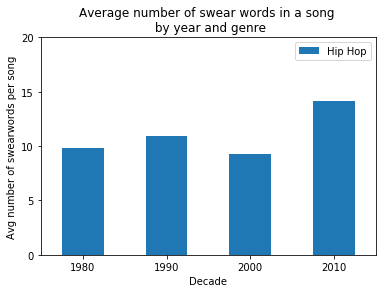

In [338]:
# Only continue with songs from 1980's and forth
g1 = g1.loc[g1['Year_decade'] >= 1980]

# Create bar plot 
import matplotlib.pyplot as plt 

g1 = g1[['Genre', 'Year_decade', 'Profanity_count']]

ax = g1.pivot('Year_decade','Genre',  'Profanity_count').plot(kind='bar')
ax.set_title('Average number of swear words in a song \n by year and genre')
plt.ylabel('Avg number of swearwords per song')
plt.xlabel('Decade')
plt.xticks(rotation='horizontal')
plt.yticks(np.arange(0, 25, step=5))

plt.legend(loc=1)
plt.show()

# Sentiment analysis

In [105]:
# Applying dummy for genre

dummy=pd.get_dummies(data["Genre"])
df = pd.concat([data, dummy], axis=1)

### Applying the NRC lexicon from Stanford

In [93]:
import pandas as pd
import numpy as np
filepath = "http://web.stanford.edu/class/cs124/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
lexicon_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')

lexicon_word = lexicon_df.pivot(columns='emotion', values='association', index='word') #.reset_index()
lexicon_word = lexicon_word[1:]

### Creating function to count words by sentiments

In [94]:
feeling_set = {k: set(lexicon_word[lexicon_word[k] == 1].index) for k in lexicon_word.columns}

def feeling_counter(l):
    res = {
        "anger": 0,
        "anticipation": 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0, 
        'negative': 0, 
        'positive': 0, 
        'sadness': 0, 
        'surprise': 0, 
        'trust': 0
     }
    for word in l:
        for key in res.keys():
            if word in feeling_set[key]:
                res[key] += 1
    return res

In [95]:
# Testing
feeling_counter(["disgust", "serious", "what", "gross"])

{'anger': 1,
 'anticipation': 0,
 'disgust': 2,
 'fear': 1,
 'joy': 0,
 'negative': 2,
 'positive': 0,
 'sadness': 1,
 'surprise': 0,
 'trust': 0}

In [96]:
# Adding the count to the dataframe
df2 = pd.concat([df, pd.DataFrame(df["Lyrics"].apply(feeling_counter).tolist())], axis=1)

## Investigating the data

In [97]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns 

%matplotlib inline 

In [125]:
# Removing all unnessesary columns for the analysis
df_clean=df2.drop(columns='Lyrics')
df_clean=df_clean.drop(columns='Title')
df_clean=df_clean.drop(columns='Profanity_count')


### Sentiments: genre

In [126]:
# Specifying data for the visuals
df_sorted=df_clean.groupby("Genre").mean()
df_sentiment1 = df_sorted[["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]]  
df_sentiment_trans=df_sentiment.transpose()

# Dividing with the sum to compare
sum_hip=sum(df_sentiment_trans["Hip Hop"])
# sum_pop=sum(df_sentiment_trans["Pop"])

df_sentiment_trans["Hip Hop"]=df_sentiment_trans["Hip Hop"].divide(sum_hip)
# df_sentiment_trans["Pop"]=df_sentiment_trans["Pop"].divide(sum_pop)

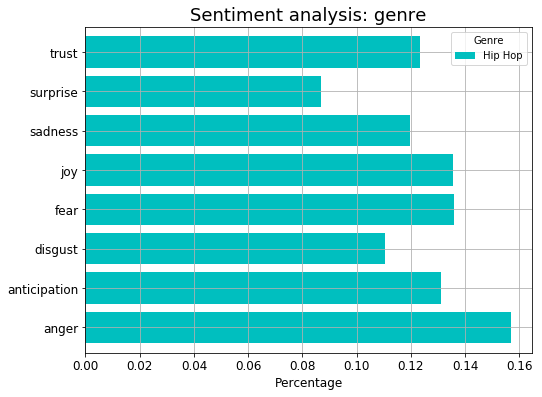

In [127]:
# Creating the visuals
df_sent = df_sentiment_trans.plot(kind="barh", fontsize=12, grid=True, color=["c", "#D14E46"], width=0.8, figsize=(8, 6))
df_sent.set_title('Sentiment analysis: genre', fontsize=18)
df_sent.set_xlabel('Percentage', fontsize=12)
df_sent.figure.savefig('Sentiment_analysis_genre_b')

# problem - nogle ord er i flere kasser? er dette et problem?

### Sentiments: year

In [128]:
df_year_group=df_clean.groupby(["Genre", "Year_decade"]).mean()
df_year_group

Hip Hop      anger  anticipation    disgust       fear  \
Genre   Year_decade                                                           
Hip Hop 1980.0           1.0  24.571429     18.428571  15.857143  21.428571   
        1990.0           1.0  13.822581     13.790323   9.822581  12.290323   
        2000.0           1.0  18.053191     13.765957  12.617021  14.819149   
        2010.0           1.0  15.716981     13.113208  11.396226  14.773585   

                           joy   negative   positive    sadness  surprise  \
Genre   Year_decade                                                         
Hip Hop 1980.0       19.571429  38.857143  35.142857  14.714286  8.428571   
        1990.0       15.822581  26.258065  27.870968  10.564516  8.516129   
        2000.0       14.042553  30.553191  25.021277  13.648936  9.776596   
        2010.0       12.000000  27.849057  24.339623  12.773585  8.867925   

                         trust  
Genre   Year_decade             
Hip Hop 1980.0       22.714286  
        1990.0       13.306452  
        2000.0       12.297872  
        2010.0       12.509434

In [129]:
# Creating visuals for Hip Hop across the years

df_year_hiphop=df_year_group.loc[df_year_group["Genre"]=="Hip Hop"]
df_year_hip_mean=df_year_hiphop.groupby(["Year"]).mean()
df_year_hip_trans=df_year_hip_mean.transpose()

df_sent2 = df_year_hip_trans.plot(fontsize=12, grid=True, figsize=(8, 6))
df_sent2.set_title(' Hiphop sentiment analysis: years', fontsize=18)
df_sent2.set_ylabel('Number of words', fontsize=12)
df_sent2.figure.savefig('Sentiment_analysis_years_hiphop')
df_sent2.tick_params(axis='x', labelrotation=70)

# https://htmlcolorcodes.com/    <-- Hjemmeside til farver

KeyError: 'Genre'

In [ ]:
# Creating visuals for Rock across the years
df_year_rock=df_year_group.loc[df_year_group["Genre"]=="Rock"]
df_year_rock_mean=df_year_rock.groupby(["Year"]).mean()
df_year_rock_trans=df_year_rock_mean.transpose()

df_sent3 = df_year_rock_trans.plot(fontsize=12, grid=True, figsize=(8, 6))
df_sent3.set_title('Rock sentiment analysis: years', fontsize=18)
df_sent3.set_ylabel('Number of words', fontsize=12)
df_sent3.figure.savefig('Sentiment_analysis_years_rock')
df_sent3.tick_params(axis='x', labelrotation=70)

# https://htmlcolorcodes.com/    <-- Hjemmeside til farver

In [ ]:
# Adding the two figures together
fig, axes = plt.subplots(1,2)

a = df_year_hip_trans.plot(fontsize=12, grid=True, figsize=(8, 6))
a.set_title('Rock sentiment analysis: years', fontsize=18)
a.set_ylabel('Number of words', fontsize=12)
a.tick_params(axis='x', labelrotation=70)

b = df_year_rock_trans.plot(fontsize=12, grid=True, figsize=(8, 6))
b.set_ylabel('Number of words', fontsize=12)
b.tick_params(axis='x', labelrotation=70)